In [1]:
import os
import glob
import re
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from collections import deque
from torch.utils.data import DataLoader

# CUDA 메모리 설정
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
#############################################
# 1. 유틸리티 함수들
#############################################

def create_signed_sdf(grid):
    """
    맨해튼 거리 기반 Signed Distance Field (SDF)
    - 경계면: 암석-공극 경계의 셀
    - 거리는 경계면 셀의 중심부터 셀 중심까지의 Manhattan 거리 + 0.5
    - 암석(m=0)은 +, 공극(m=1)은 -
    """
    rows, cols = grid.shape
    # 경계면 셀 찾기
    seeds = []
    dirs = [(-1,0),(1,0),(0,-1),(0,1)]
    for i in range(rows):
        for j in range(cols):
            for di, dj in dirs:
                ni, nj = i+di, j+dj
                if 0 <= ni < rows and 0 <= nj < cols:
                    if grid[ni, nj] != grid[i, j]:
                        seeds.append((i, j))
                        break
    # BFS로 Manhattan 거리 계산
    dist = np.full((rows, cols), -1, dtype=np.int32)
    q = deque()
    for (i, j) in seeds:
        dist[i, j] = 0
        q.append((i, j))
    while q:
        i, j = q.popleft()
        for di, dj in dirs:
            ni, nj = i+di, j+dj
            if 0 <= ni < rows and 0 <= nj < cols and dist[ni, nj] == -1:
                dist[ni, nj] = dist[i, j] + 1
                q.append((ni, nj))
    # sign mask: 암석(m=0)->+1, 공극(m=1)->-1
    sign = np.where(grid == 0, 1.0, -1.0)
    sdf = (dist.astype(np.float32) + 0.5) * sign
    return sdf

In [3]:
#############################################
# 2. 데이터 로드 및 전처리 함수들
#############################################

def load_velocity_data(npz_dir):
    v_files = sorted(glob.glob(os.path.join(npz_dir, "v*.npz")),
                     key=lambda x: int(re.search(r"v(\d+)\.npz", os.path.basename(x)).group(1)))
    domain_data = []
    for v_file in v_files:
        m_obj = re.search(r"v(\d+)\.npz", os.path.basename(v_file))
        if m_obj is None:
            continue
        domain_num = int(m_obj.group(1))
        m_file = os.path.join(npz_dir, f"m{domain_num}.npz")
        if not os.path.exists(m_file):
            continue
        with np.load(v_file) as data:
            v_flat = data['v']
            n_elements = 64 * 148
            x_data = v_flat[:n_elements].reshape((64, 148))
            y_data = v_flat[n_elements:].reshape((64, 148))
            v_data = np.stack([x_data, y_data], axis=-1)
        with np.load(m_file) as data:
            m_data = data['m']
            if m_data.ndim == 1:
                m_data = m_data.reshape((64, 148))
            elif m_data.ndim == 3:
                m_data = m_data[0]
            # 확실히 0/1로 이진화!
            m_data = (m_data > 0.5).astype(int)
        domain_data.append({'domain_num': domain_num, 'v': v_data, 'm': m_data})
    return domain_data


def process_velocity_domain(domain_data, nx=64, ny=148):
    domain_num = domain_data['domain_num']
    v_data = domain_data['v']
    m_data = domain_data['m']
    
    # Branch input: 매질 마스크
    branch_input = m_data.reshape((1, nx, ny))
    
    # SDF 계산
    sdf = create_signed_sdf(m_data)
    sdf_flat = sdf.flatten().astype(np.float32)
    
    # Trunk input: [x, y, SDF]
    x_coords = np.arange(nx, dtype=np.float32)
    y_coords = np.arange(ny, dtype=np.float32)
    X, Y = np.meshgrid(x_coords, y_coords, indexing="ij")
    x_flat = X.flatten()
    y_flat = Y.flatten()
    trunk_query = np.stack([x_flat, y_flat, sdf_flat], axis=1)  # (L, 3)
    trunk_inputs = trunk_query[np.newaxis, ...]                # (1, L, 3)
    
    # Target: 유속장 정규화
    epsilon = 1e-8
    target = v_data.astype(np.float32)
    u_x, u_y = target[..., 0], target[..., 1]
    u_x_min, u_x_max = u_x.min(), u_x.max()
    u_y_min, u_y_max = u_y.min(), u_y.max()
    target_norm = np.empty_like(target)
    target_norm[..., 0] = (u_x - u_x_min) / (u_x_max - u_x_min + epsilon)
    target_norm[..., 1] = (u_y - u_y_min) / (u_y_max - u_y_min + epsilon)
    norm_params = {'u_x_min': u_x_min, 'u_x_max': u_x_max,
                   'u_y_min': u_y_min, 'u_y_max': u_y_max}
    
    return domain_num, branch_input, trunk_inputs, target_norm, norm_params


def build_velocity_dataset(domain_list, nx=64, ny=148):
    branch_list, trunk_list, target_list, norm_params_list = [], [], [], []
    for d in domain_list:
        _, b, t, y, p = process_velocity_domain(d, nx, ny)
        branch_list.append(b)
        trunk_list.append(t)
        target_list.append(y)
        norm_params_list.append(p)
    return branch_list, trunk_list, target_list, norm_params_list

In [4]:
#############################################
# 3. 데이터셋 구성
#############################################
npz_dir = "/home/yehoon/npz/amv/npz_test"
all_domains = load_velocity_data(npz_dir)

group1 = [d for d in all_domains if 1 <= d['domain_num'] <= 3000]
group2 = [d for d in all_domains if 3001 <= d['domain_num'] <= 6000]
group3 = [d for d in all_domains if 6001 <= d['domain_num'] <= 9000]

random.seed(42)
def split_group(group, train_count=2700):
    random.shuffle(group)
    return group[:train_count], group[train_count:]

train_domains = sum([split_group(g)[0] for g in [group1,group2,group3]], [])
test_domains  = sum([split_group(g)[1] for g in [group1,group2,group3]], [])

train_b, train_t, train_y, train_p = build_velocity_dataset(train_domains)
test_b,  test_t,  test_y,  test_p  = build_velocity_dataset(test_domains)

train_branch = torch.tensor(np.stack(train_b), dtype=torch.float32)
train_trunk  = torch.tensor(np.stack(train_t), dtype=torch.float32)
train_target = torch.tensor(np.stack(train_y), dtype=torch.float32)

test_branch  = torch.tensor(np.stack(test_b), dtype=torch.float32)
test_trunk   = torch.tensor(np.stack(test_t), dtype=torch.float32)
test_target  = torch.tensor(np.stack(test_y), dtype=torch.float32)

train_dataset = TensorDataset(train_branch, train_trunk, train_target)
test_dataset  = TensorDataset(test_branch,  test_trunk,  test_target)


In [5]:
#############################################
# 4. 수정된 모델 구성 – VelocityDeepONet
#############################################
class BasicCNN(nn.Module):
    def __init__(self, in_channels, out_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, 1, 1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.SiLU(), nn.AvgPool2d(2)
        )
        self.fc = nn.Linear(64 * 8 * 18, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def create_trunk_net(trunk_in_dim, out_dim, num_layers=6, width=80):
    layers = [nn.Linear(trunk_in_dim, width), nn.SiLU()]
    for _ in range(num_layers-2):
        layers += [nn.Linear(width, width), nn.SiLU()]
    layers += [nn.Linear(width, 2*out_dim), nn.SiLU()]
    return nn.Sequential(*layers)

class VelocityDeepONet(nn.Module):
    def __init__(self, branch_in_dim=1, trunk_in_dim=3, out_dim=100, num_layers=6, width=80, nx=64, ny=148):
        super().__init__()
        self.branch_net = BasicCNN(branch_in_dim, 2*out_dim)
        self.trunk_net  = create_trunk_net(trunk_in_dim, out_dim, num_layers, width)
        self.bias = nn.Parameter(torch.zeros(2))
        self.nx, self.ny = nx, ny

    def forward(self, branch_input, trunk_input):
        # branch_input: [N, 1, nx, ny]
        # trunk_input: [N, 1, L, 3]
        N, T, L, D = trunk_input.shape
        # Trunk: (N*T*L, D)
        trunk_flat = trunk_input.view(-1, D)
        trunk_out  = self.trunk_net(trunk_flat)             # (N*T*L, 2*p)
        trunk_out  = trunk_out.view(N, T, L, 2, -1)        # (N,1,L,2,p)
        # Branch: (N,2*p)
        branch_out = self.branch_net(branch_input)          # (N,2*p)
        branch_out = branch_out.view(N, 2, -1)
        branch_out = branch_out.unsqueeze(1).unsqueeze(2)    # (N,1,1,2,p)
        # Inner product
        out = torch.sum(branch_out * trunk_out, dim=-1) + self.bias  # (N,1,L,2)
        return out.view(N, self.nx, self.ny, 2)

In [6]:
def train_model(model, train_dataset, test_dataset, num_epochs=100, lr=0.001, batch_size=25, patience=15):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.HuberLoss(delta=1.0)
    scaler = torch.cuda.amp.GradScaler()

    class EarlyStopping:
        def __init__(self, patience=10, delta=1e-5, verbose=False):
            self.patience = patience
            self.delta = delta
            self.verbose = verbose
            self.counter = 0
            self.best_loss = None
            self.early_stop = False
            self.best_model_state = None
        def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.delta:
                self.best_loss = val_loss
                self.counter = 0
                self.best_model_state = copy.deepcopy(model.state_dict())
                if self.verbose:
                    print(f"Validation loss decreased. New best loss: {val_loss:.6f}")
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True

    early_stopping = EarlyStopping(patience=patience, delta=1e-5, verbose=True)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # --- training ---
        model.train()
        running_train_loss = 0.0
        for b, t, y in train_loader:  # <--- 수정! (3개만 언팩)
            b, t, y = b.cuda(), t.cuda(), y.cuda()
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                preds = model(b, t)    # <--- 수정! (입력 2개)
                loss = criterion(preds, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- validation ---
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for b, t, y in test_loader:  # <--- 수정! (3개만 언팩)
                b, t, y = b.cuda(), t.cuda(), y.cuda()
                with torch.cuda.amp.autocast():
                    preds = model(b, t)   # <--- 수정! (입력 2개)
                    loss = criterion(preds, y)
                running_test_loss += loss.item()
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

        early_stopping(avg_test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring best model state.")
            model.load_state_dict(early_stopping.best_model_state)
            break

    return train_losses, test_losses

In [7]:
model = VelocityDeepONet(
    branch_in_dim=1,
    trunk_in_dim=3,
    out_dim=500,
    num_layers=8,
    width=500,
    nx=64,
    ny=148
)

train_losses, test_losses = train_model(
    model,
    train_dataset,
    test_dataset,
    num_epochs=1000,
    lr=0.001,
    batch_size=25,
    patience=15
)

/tmp/ipykernel_1111993/1932592381.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_1111993/1932592381.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1111993/1932592381.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/1000] Train Loss: 0.019427, Test Loss: 0.009732
Validation loss decreased. New best loss: 0.009732
Epoch [2/1000] Train Loss: 0.009806, Test Loss: 0.009558
Validation loss decreased. New best loss: 0.009558
Epoch [3/1000] Train Loss: 0.009763, Test Loss: 0.009639
No improvement: 1/15
Epoch [4/1000] Train Loss: 0.009478, Test Loss: 0.009277
Validation loss decreased. New best loss: 0.009277
Epoch [5/1000] Train Loss: 0.009333, Test Loss: 0.009885
No improvement: 1/15
Epoch [6/1000] Train Loss: 0.009155, Test Loss: 0.008899
Validation loss decreased. New best loss: 0.008899
Epoch [7/1000] Train Loss: 0.009029, Test Loss: 0.008805
Validation loss decreased. New best loss: 0.008805
Epoch [8/1000] Train Loss: 0.008780, Test Loss: 0.008533
Validation loss decreased. New best loss: 0.008533
Epoch [9/1000] Train Loss: 0.008617, Test Loss: 0.008205
Validation loss decreased. New best loss: 0.008205
Epoch [10/1000] Train Loss: 0.008350, Test Loss: 0.007990
Validation loss decreased. New

In [8]:
#############################################
# 후보정 및 후보정 기반 시각화 함수들 (유속)
#############################################

def apply_candidate_correction(arr, mask):
    """마스크가 암석(0)인 부분은 0으로 보정"""
    arr = arr.copy()
    arr[mask < 0.5] = 0
    return arr


def inverse_normalize(arr, norm_param):
    """정규화 역변환 (정규화에 사용된 min/max 필요)"""
    # arr shape: (64,148,2)
    x = arr[..., 0] * (norm_param['u_x_max'] - norm_param['u_x_min']) + norm_param['u_x_min']
    y = arr[..., 1] * (norm_param['u_y_max'] - norm_param['u_y_min']) + norm_param['u_y_min']
    return np.stack([x, y], axis=-1)


def visualize_results_velocity_corrected(
    model: torch.nn.Module,
    branch_tensor: torch.Tensor,
    trunk_tensor: torch.Tensor,
    target_tensor: torch.Tensor,
    sample_idx: int,
    norm_params: dict = None,
    save_svg: str = None
) -> None:
    """
    실제(simulation) vs 예측(DeepONet) 유속 필드를 2x2 그리드로 비교 시각화합니다.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        b = branch_tensor[sample_idx:sample_idx+1].to(device)
        t = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(b, t).cpu().numpy()[0]
        actual = target_tensor[sample_idx].cpu().numpy()

    if norm_params:
        preds = inverse_normalize(preds, norm_params)
        actual = inverse_normalize(actual, norm_params)

    mask = branch_tensor[sample_idx, 0].cpu().numpy()
    p_corr = apply_candidate_correction(preds, mask)
    a_corr = apply_candidate_correction(actual, mask)

    ux_sim, ux_pred = a_corr[..., 0], p_corr[..., 0]
    uy_sim, uy_pred = a_corr[..., 1], p_corr[..., 1]

    vmin_x, vmax_x = ux_sim.min(), ux_sim.max()
    vmin_y, vmax_y = uy_sim.min(), uy_sim.max()

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    axes[0,0].imshow(ux_sim, vmin=vmin_x, vmax=vmax_x)
    axes[0,0].set_title('Simulation u_x')
    im = axes[0,1].imshow(ux_pred, vmin=vmin_x, vmax=vmax_x)
    axes[0,1].set_title('Predicted u_x')
    fig.colorbar(im, ax=axes[0,:], orientation='vertical')

    axes[1,0].imshow(uy_sim, vmin=vmin_y, vmax=vmax_y)
    axes[1,0].set_title('Simulation u_y')
    im2 = axes[1,1].imshow(uy_pred, vmin=vmin_y, vmax=vmax_y)
    axes[1,1].set_title('Predicted u_y')
    fig.colorbar(im2, ax=axes[1,:], orientation='vertical')

    if save_svg:
        fig.savefig(save_svg)
    plt.show()


def scatter_velocity_corrected(
    preds_denorm: np.ndarray,
    actual_denorm: np.ndarray,
    mask: np.ndarray,
    save_svg: str = None
) -> None:
    """
    후보정된 예측 vs 실제 u_x, u_y 산점도를 그립니다.
    """
    p_corr = apply_candidate_correction(preds_denorm, mask)
    a_corr = apply_candidate_correction(actual_denorm, mask)

    plt.figure(figsize=(12,5))
    # u_x
    plt.subplot(1, 2, 1)
    plt.scatter(a_corr[...,0].ravel(), p_corr[...,0].ravel(), alpha=0.5)
    m, M = a_corr[...,0].min(), a_corr[...,0].max()
    plt.plot([m,M],[m,M],'r--')
    plt.title('u_x scatter')
    # u_y
    plt.subplot(1, 2, 2)
    plt.scatter(a_corr[...,1].ravel(), p_corr[...,1].ravel(), alpha=0.5)
    m2, M2 = a_corr[...,1].min(), a_corr[...,1].max()
    plt.plot([m2,M2],[m2,M2],'r--')
    plt.title('u_y scatter')

    if save_svg:
        plt.savefig(save_svg)
    plt.show()


def visualize_error_heatmaps(
    error: np.ndarray,
    title: str,
    vmin: float,
    vmax: float,
    cmap: str = 'bwr',
    save_svg: str = None
) -> None:
    """
    단일 error heatmap(퍼센트 혹은 절대)을 시각화합니다.
    """
    plt.figure(figsize=(6,5))
    im = plt.imshow(error, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.colorbar(im)
    if save_svg:
        plt.savefig(save_svg)
    plt.show()


def compute_errors(model, branch_tensor, trunk_tensor, target_tensor, norm_params, sample_idx):
    """
    예측 및 실제를 가져와 후보정 및 역정규화 후
    - percent_error_u/v
    - abs_error_u/v
    반환
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        b = branch_tensor[sample_idx:sample_idx+1].to(device)
        t = trunk_tensor[sample_idx:sample_idx+1].to(device)
        pred = model(b, t).cpu().numpy()[0]
        actual = target_tensor[sample_idx].numpy()

    pred = inverse_normalize(pred, norm_params)
    actual = inverse_normalize(actual, norm_params)
    mask = branch_tensor[sample_idx,0].numpy()

    p_corr = apply_candidate_correction(pred, mask)
    a_corr = apply_candidate_correction(actual, mask)

    eps = 1e-8
    percent_u = ((p_corr[...,0] - a_corr[...,0]) / (np.abs(a_corr[...,0])+eps) * 100).clip(-10,10)
    percent_v = ((p_corr[...,1] - a_corr[...,1]) / (np.abs(a_corr[...,1])+eps) * 100).clip(-10,10)
    abs_u = np.abs(p_corr[...,0] - a_corr[...,0])
    abs_v = np.abs(p_corr[...,1] - a_corr[...,1])

    return percent_u, percent_v, abs_u, abs_v

def compute_nrmse_velocity_corrected(preds, actual, mask):
    """마스킹된 영역만 NRMSE 계산"""
    # mask: 0(암석), 1(공극)
    area = (mask > 0.5)
    if area.sum() == 0:
        return 0.0
    pred_flat = preds[area]
    actual_flat = actual[area]
    rmse = np.sqrt(np.mean((pred_flat - actual_flat) ** 2))
    denom = np.max(actual_flat) - np.min(actual_flat) + 1e-8
    nrmse = rmse / denom
    return nrmse

def evaluate_sample_velocity(model, test_branch, test_trunk, test_target, idx):
    # 입력: tensor들, idx 번째 샘플
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        branch = test_branch[idx:idx+1].to(device)
        trunk = test_trunk[idx:idx+1].to(device)
        target = test_target[idx:idx+1].to(device)
        preds = model(branch, trunk)   # [1, 64, 148, 2]
        preds_np = preds.cpu().numpy()[0]
        target_np = target.cpu().numpy()[0]
        return preds_np, target_np

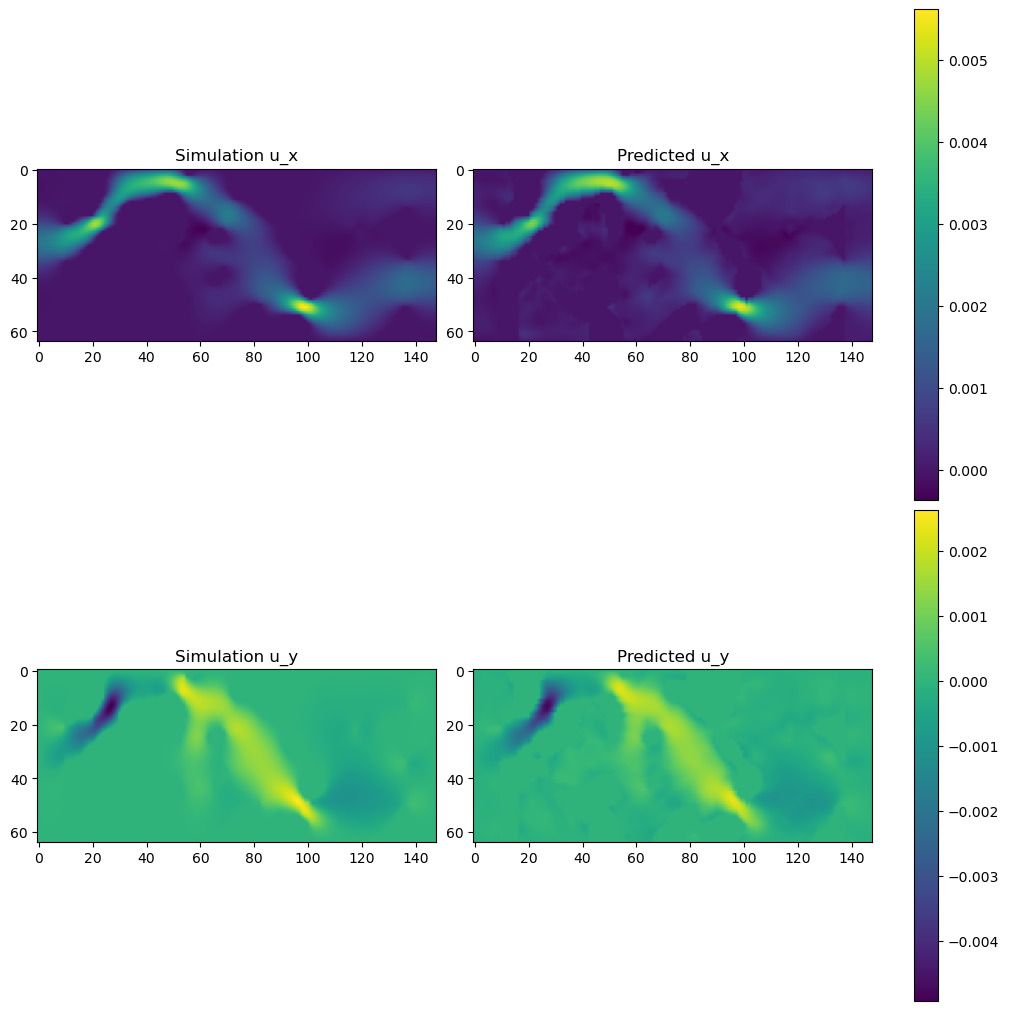

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# 3) 시각화할 샘플 인덱스
sample_idx = 0

# 4) 2×2 필드 비교
norm_params = test_p[sample_idx]                           # 도메인마다 저장해둔 정규화 파라미터
visualize_results_velocity_corrected(
    model,
    test_branch,    # torch.Tensor, shape = (N,1,nx,ny)
    test_trunk,     # torch.Tensor, shape = (N,1,nx*ny,3)
    test_target,    # torch.Tensor, shape = (N,nx,ny,2)
    sample_idx,
    norm_params,
    save_svg="field_comparison.svg"  # 저장을 원치 않으면 이 인자 생략
)

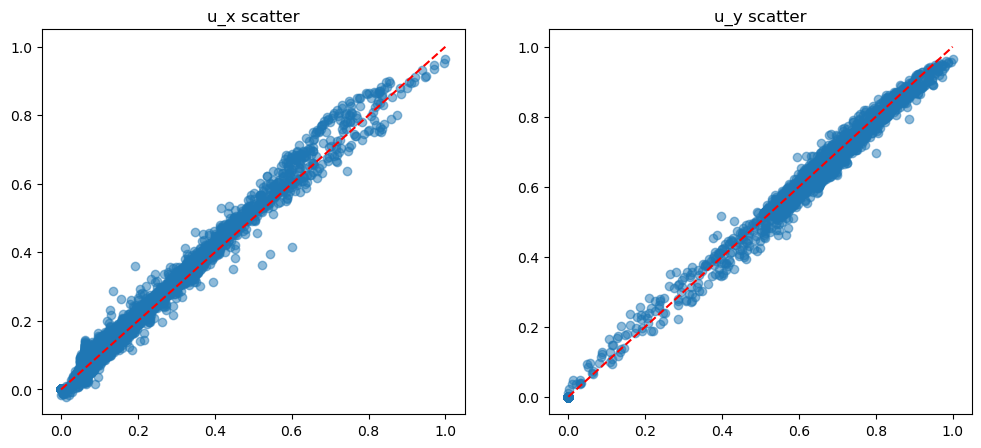

In [10]:
with torch.no_grad():
    b = test_branch[sample_idx:sample_idx+1].to(device)
    t = test_trunk[sample_idx:sample_idx+1].to(device)
    pred_field = model(b, t).cpu().numpy()[0]          # (nx,ny,2)
actual_field = test_target[sample_idx].numpy()         # (nx,ny,2)
mask = test_branch[sample_idx,0].numpy()               # (nx,ny), 0=광물

scatter_velocity_corrected(
    pred_field,
    actual_field,
    mask,
    save_svg="scatter_u.png"
)

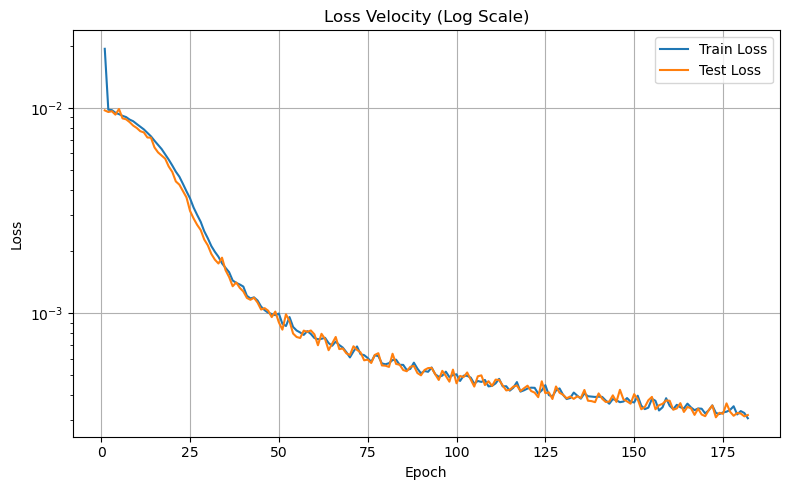

In [11]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))

# 선 그래프를 그리고
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses,  label='Test Loss')

# 로그 스케일 설정 (y축만)
plt.yscale('log')

# (원하시면 x축도 로그 스케일로)
# plt.xscale('log')

# 축 라벨, 제목, 범례, 그리드
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Velocity (Log Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# SVG로 저장
plt.savefig("velocity_loss_log.svg", format="svg")
plt.show()


In [12]:
# 모든 테스트 샘플의 NRMSE 계산
errors = []
for idx in range(len(test_branch)):
    preds, actual = evaluate_sample_velocity(
        model, 
        test_branch, 
        test_trunk, 
        test_target, 
        idx
    )
    mask = test_branch[idx].cpu().numpy()[0]
    nrmse = compute_nrmse_velocity_corrected(preds, actual, mask)
    errors.append(nrmse)

errors = np.array(errors)
best_idx = int(np.argmin(errors))
best_domain = test_domains[best_idx]['domain_num']
best_nrmse = errors[best_idx]

print(f"가장 오차가 작은 테스트 인덱스: {best_idx}")
print(f"해당 도메인 번호         : {best_domain}")
print(f"최대 NRMSE 값           : {best_nrmse:.4f}")


가장 오차가 작은 테스트 인덱스: 223
해당 도메인 번호         : 210
최대 NRMSE 값           : 0.0175


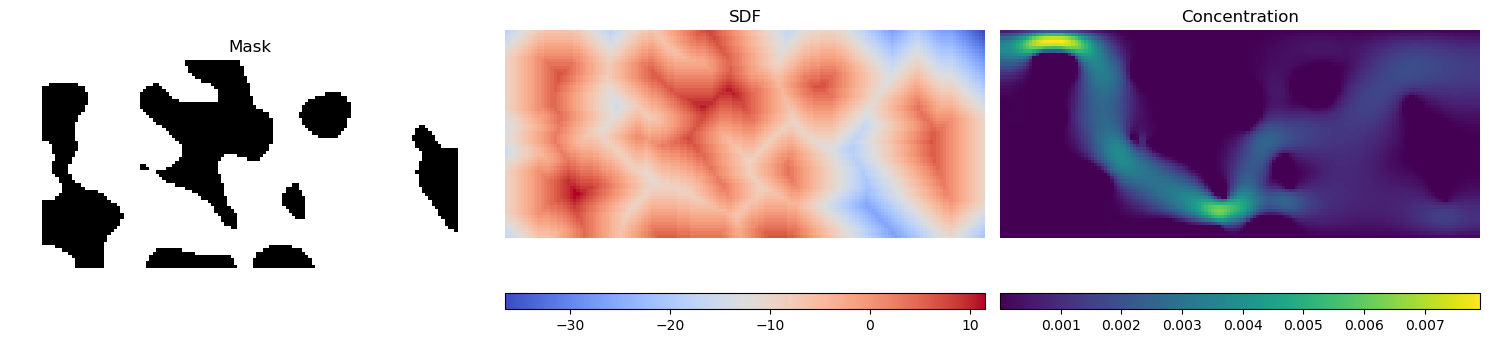

In [13]:
test_idx = 838

# 1. 마스크 이미지
mask_img = test_branch[test_idx, 0].cpu().numpy()    # (64,148)

# 2. SDF 이미지
sdf_flat = test_trunk[test_idx, 0, :, 2].cpu().numpy()
sdf_img = sdf_flat.reshape(mask_img.shape)

# 3. 유속 벡터 (정규화 해제)
# 정규화 파라미터 가져오기
norm_p = test_p[test_idx]
u_x_min, u_x_max = norm_p['u_x_min'], norm_p['u_x_max']
u_y_min, u_y_max = norm_p['u_y_min'], norm_p['u_y_max']

# 정규화된 벡터
vel_norm = test_target[test_idx].cpu().numpy()   # (64,148,2)
u_x = vel_norm[..., 0] * (u_x_max - u_x_min) + u_x_min
u_y = vel_norm[..., 1] * (u_y_max - u_y_min) + u_y_min
vel_vec = np.stack([u_x, u_y], axis=-1)         # (64,148,2)
vel_mag = np.linalg.norm(vel_vec, axis=-1)      # (64,148)

# --- 시각화 (origin='lower' 옵션 없음) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(mask_img, cmap='gray')
axes[0].set_title("Mask")
axes[0].axis('off')

im1 = axes[1].imshow(sdf_img, cmap='coolwarm')
axes[1].set_title("SDF")
axes[1].axis('off')
# 가로 컬러바
cbar1 = plt.colorbar(im1, ax=axes[1], orientation='horizontal', shrink=1, pad=0.15, aspect=30)

im2 = axes[2].imshow(vel_mag, cmap='viridis')
axes[2].set_title("Concentration")
axes[2].axis('off')
# 가로 컬러바
cbar2 = plt.colorbar(im2, ax=axes[2], orientation='horizontal', shrink=1, pad=0.15, aspect=30)

plt.tight_layout()
plt.savefig("DON_v.svg", format="svg")
plt.show()


In [14]:
print(sdf_flat.shape)
print("최소값:", sdf_flat.min())
print("최대값:", sdf_flat.max())
print("평균:", sdf_flat.mean())
print("중간값:", np.median(sdf_flat))
print("앞부분 10개:", sdf_flat[:10])

print("0(암석) 개수:", np.sum(mask_img==0))
print("1(공극) 개수:", np.sum(mask_img==1))
print("mask_img 고유값:", np.unique(mask_img))


(9472,)
최소값: -36.5
최대값: 11.5
평균: -4.959565
중간값: -4.5
앞부분 10개: [-17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5]
0(암석) 개수: 2472
1(공극) 개수: 7000
mask_img 고유값: [0. 1.]


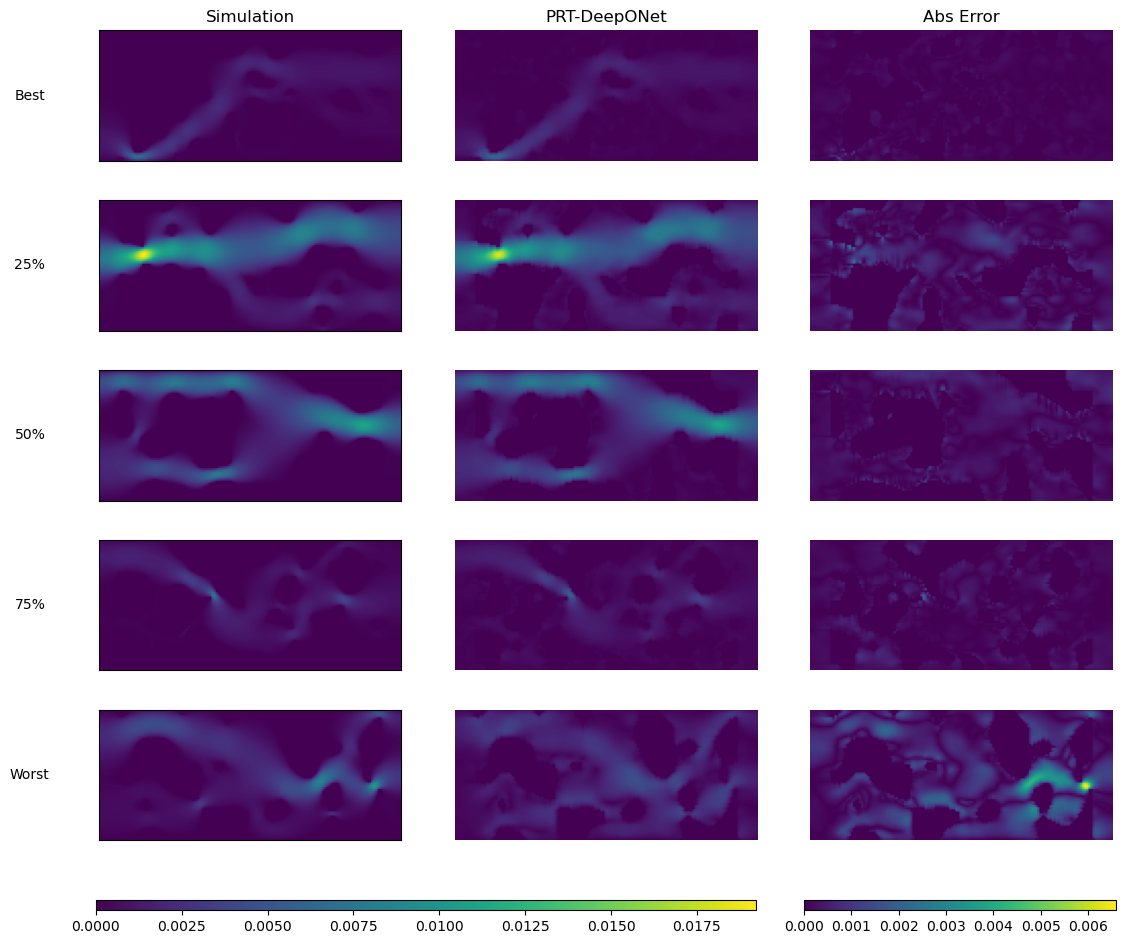

In [15]:
# --- 1) NRMSE 계산 및 분위수 샘플 추출 ---
nrmse_list = []
num_samples = len(test_branch)
for idx in range(num_samples):
    preds_norm, actual_norm = evaluate_sample_velocity(
        model,
        test_branch,
        test_trunk,
        test_target,
        idx
    )
    mask = test_branch[idx].cpu().numpy()[0]
    nrmse_list.append(compute_nrmse_velocity_corrected(preds_norm, actual_norm, mask))
nrmse_arr = np.array(nrmse_list)

best_idx  = nrmse_arr.argmin()
worst_idx = nrmse_arr.argmax()
sorted_idx = np.argsort(nrmse_arr)
idx25 = sorted_idx[int(0.25 * len(sorted_idx))]
idx50 = sorted_idx[int(0.50 * len(sorted_idx))]
idx75 = sorted_idx[int(0.75 * len(sorted_idx))]
sample_indices = [best_idx, idx25, idx50, idx75, worst_idx]
row_labels     = ["Best", "25%", "50%", "75%", "Worst"]

# --- 2) 전역 vmin/vmax 계산 (예측/실제 벡터장의 크기, 오차) ---
mag_vals, err_vals = [], []
for idx in sample_indices:
    preds_norm, actual_norm = evaluate_sample_velocity(
        model, test_branch, test_trunk, test_target, idx
    )
    preds_denorm  = inverse_normalize(preds_norm,  test_p[idx])
    actual_denorm = inverse_normalize(actual_norm, test_p[idx])
    mask = test_branch[idx].cpu().numpy()[0]
    preds_corr  = apply_candidate_correction(preds_denorm,  mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)
    mag_pred = np.linalg.norm(preds_corr, axis=-1)
    mag_act  = np.linalg.norm(actual_corr, axis=-1)
    mag_vals.extend([mag_act.flatten(), mag_pred.flatten()])
    err_vals.append(np.abs(mag_pred - mag_act).flatten())

mag_all = np.concatenate(mag_vals)
err_all = np.concatenate(err_vals)
vmin_mag, vmax_mag = mag_all.min(), mag_all.max()
vmin_err, vmax_err = 0.0, err_all.max()

# --- 3) 5×3 그리드 플롯 ---
fig, axes = plt.subplots(5, 3, figsize=(12, 10))
plt.subplots_adjust(top=0.93, bottom=0.12, left=0.10, right=0.95,
                    hspace=0.3, wspace=0.15)

for row, idx in enumerate(sample_indices):
    preds_norm, actual_norm = evaluate_sample_velocity(
        model, test_branch, test_trunk, test_target, idx
    )
    preds_denorm  = inverse_normalize(preds_norm,  test_p[idx])
    actual_denorm = inverse_normalize(actual_norm, test_p[idx])
    mask = test_branch[idx].cpu().numpy()[0]
    preds_corr  = apply_candidate_correction(preds_denorm,  mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)
    mag_pred = np.linalg.norm(preds_corr, axis=-1)
    mag_act  = np.linalg.norm(actual_corr, axis=-1)
    mag_err  = np.abs(mag_pred - mag_act)

    # Column 0: Simulation |v|
    ax0 = axes[row, 0]
    im0 = ax0.imshow(mag_act, origin='lower',
                     vmin=vmin_mag, vmax=vmax_mag,
                     cmap='viridis')
    ax0.set_ylabel(row_labels[row], rotation=0, labelpad=50, va='center')
    if row == 0:
        ax0.set_title("Simulation")
    ax0.set_xticks([]); ax0.set_yticks([])

    # Column 1: DeepONet |v|
    ax1 = axes[row, 1]
    im1 = ax1.imshow(mag_pred, origin='lower',
                     vmin=vmin_mag, vmax=vmax_mag,
                     cmap='viridis')
    if row == 0:
        ax1.set_title("PRT-DeepONet")
    ax1.axis('off')

    # Column 2: Absolute Error
    ax2 = axes[row, 2]
    im2 = ax2.imshow(mag_err, origin='lower',
                     vmin=vmin_err, vmax=vmax_err,
                     cmap='viridis')
    if row == 0:
        ax2.set_title("Abs Error")
    ax2.axis('off')

# --- 4) 하단 컬러바 ---
cbar_ax1 = fig.add_axes([0.1, 0.05, 0.55, 0.01])
fig.colorbar(im0, cax=cbar_ax1, orientation='horizontal')
cbar_ax2 = fig.add_axes([0.69, 0.05, 0.26, 0.01])
fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')

plt.savefig("vel_per.svg", format="svg")
plt.show()


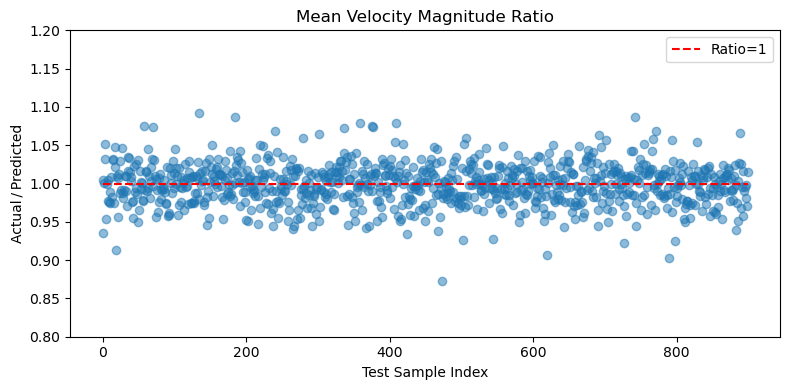

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
num_samples = len(test_branch)

# 1) 유속 비율 계산
vel_ratio = []
for idx in range(num_samples):
    sb = test_branch[idx:idx+1].to(device)
    st = test_trunk[idx:idx+1].to(device)
    with torch.no_grad():
        pred_norm = model(sb, st).cpu().numpy()[0]    # (nx, ny, 2)

    actual_norm = test_target[idx].cpu().numpy()
    mask        = test_branch[idx].cpu().numpy()[0]

    pred_mag   = np.sqrt(pred_norm[...,0]**2 + pred_norm[...,1]**2)
    actual_mag = np.sqrt(actual_norm[...,0]**2 + actual_norm[...,1]**2)

    pred_corr   = apply_candidate_correction(pred_mag, mask)
    actual_corr = apply_candidate_correction(actual_mag, mask)
    mean_pred   = pred_corr.mean()
    mean_actual = actual_corr.mean()

    vel_ratio.append(mean_actual / mean_pred if mean_pred != 0 else np.nan)

# 2) 시각화
plt.figure(figsize=(8,4))
plt.scatter(np.arange(num_samples), vel_ratio, alpha=0.5)
plt.hlines(1, 0, num_samples-1, linestyles='--', color='red', label='Ratio=1')

# y축 범위 고정
plt.ylim(0.8, 1.2)

plt.xlabel("Test Sample Index")
plt.ylabel("Actual / Predicted")
plt.title("Mean Velocity Magnitude Ratio")
plt.legend()
plt.tight_layout()

# SVG로 저장
plt.savefig("velocity_ratio.svg", format="svg")

plt.show()


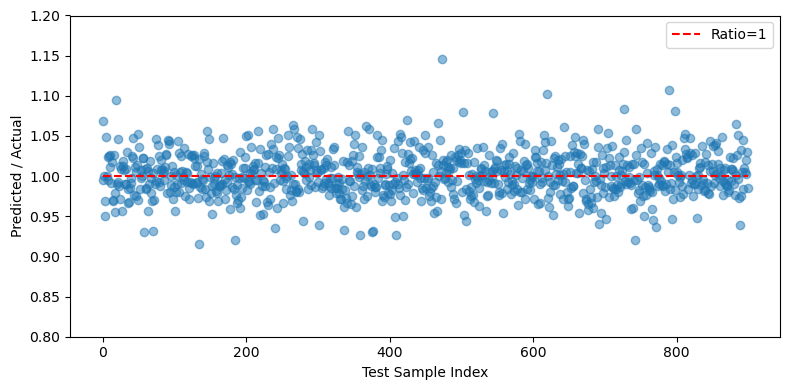

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
num_samples = len(test_branch)

vel_ratio = []
for idx in range(num_samples):
    sb = test_branch[idx:idx+1].to(device)
    st = test_trunk[idx:idx+1].to(device)
    with torch.no_grad():
        pred_norm = model(sb, st).cpu().numpy()[0]    # (nx, ny, 2)
    actual_norm = test_target[idx].cpu().numpy()
    mask = test_branch[idx].cpu().numpy()[0]

    pred_mag   = np.sqrt(pred_norm[...,0]**2 + pred_norm[...,1]**2)
    actual_mag = np.sqrt(actual_norm[...,0]**2 + actual_norm[...,1]**2)

    # 암석(mask==0)은 제외하고, 공극(mask==1)만 평균
    mean_pred   = pred_mag[mask == 1].mean()
    mean_actual = actual_mag[mask == 1].mean()

    vel_ratio.append(mean_pred / mean_actual if mean_pred != 0 else np.nan)

plt.figure(figsize=(8,4))
plt.scatter(np.arange(num_samples), vel_ratio, alpha=0.5)
plt.hlines(1, 0, num_samples-1, linestyles='--', color='red', label='Ratio=1')
plt.ylim(0.8, 1.2)
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted / Actual")
plt.legend()
plt.tight_layout()
plt.savefig("velocity_ratio.svg", format="svg")
plt.show()
